In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from torchvision import models, transforms 
from torch.autograd import Variable
import torch.optim as optim 
from torch.optim.lr_scheduler import StepLR 
from torch.utils.data import Dataset, DataLoader
from time import time
from skimage.io import imread 
import gc
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output
import os
import random

In [2]:
train_dir = os.path.join(os.getcwd(),'maps/train')
val_dir = os.path.join(os.getcwd(),'maps/val')

train_files = [os.path.join(train_dir, file) for file in os.listdir(train_dir)]
val_files = [os.path.join(val_dir, file) for file in os.listdir(val_dir)]

In [3]:
import torch

data_modes = ['train', 'val', 'test']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print(device)

cuda


In [4]:
from PIL import Image

class Maps(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        self.files = files
        self.mode = mode
        self.len_ = len(self.files)
        
    def __len__(self):
        return self.len_
    
    def load_sample(self, image_file):
        img = Image.open(image_file)
        true = img.crop((0, 0, img.width // 2, img.height))
        label = img.crop((img.width // 2, 0, img.width, img.height)) 
        return true, label
    
    def __getitem__(self, index):   
        true, label = self.load_sample(self.files[index])
    
        if self.mode == 'train':
            true = true.resize((286, 286), Image.BILINEAR)
            label = label.resize((286, 286), Image.BILINEAR)

            x = random.randint(0, 31)            
            y = random.randint(0, 31)
            
            true = true.crop((x, y, x + 256, y + 256))
            label = label.crop((x, y, x + 256, y + 256))
       
            true = true.transpose(Image.FLIP_LEFT_RIGHT)
            label = label.transpose(Image.FLIP_LEFT_RIGHT)
            
        transform = transforms.Compose([transforms.Scale(256),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
       
        true = transform(true)
        label = transform(label)
        return true, label   

In [5]:
class Downsample(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, batch_norm=True):
        super().__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.batch_norm = batch_norm
        self.bn = torch.nn.BatchNorm2d(output_size)

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)

        if self.batch_norm:
            return self.bn(out)
        else:
            return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()        
        self.down1 = Downsample(6, 64, batch_norm=False)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128,256)
        self.down4 = Downsample(256,512, stride=1)
        self.down5 = Downsample(512, 1, stride=1, batch_norm=False)

    def forward(self, in_image_src, in_image_target):
        concat = torch.cat([in_image_src, in_image_target], 1)        
        down1 = self.down1(concat)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        down5 = self.down5(down4)
        out = torch.nn.Sigmoid()(down5)
        return out
    
    def weight_init(self, mean=0.0, std=0.02):
        for child in self.children():
            if isinstance(child, Downsample):
                torch.nn.init.normal(child.conv.weight, mean, std)

In [6]:
class Upsample(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super().__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.bn = torch.nn.BatchNorm2d(output_size)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.batch_norm = batch_norm
        self.dropout = dropout

    def forward(self, x):
        if self.batch_norm:
            out = self.bn(self.deconv(self.relu(x)))
        else:
            out = self.deconv(self.relu(x))

        if self.dropout:
            return self.drop(out)
        else:
            return out
    
class Generator(nn.Module):
    def __init__(self):
        super().__init__()        
        self.down1 = Downsample(3, 64, activation=False, batch_norm=False)
        self.down2 = Downsample(64, 128)
        self.down3 = Downsample(128, 256)
        self.down4 = Downsample(256, 512)
        self.down5 = Downsample(512, 512)
        self.down6 = Downsample(512, 512)
        self.down7 = Downsample(512, 512) 
        self.down8 = Downsample(512, 512, batch_norm=False)        
        self.up1 = Upsample(512, 512, dropout=True)
        self.up2 = Upsample(1024, 512, dropout=True)
        self.up3 = Upsample(1024, 512, dropout=True)
        self.up4 = Upsample(1024, 512)
        self.up5 = Upsample(1024, 256)
        self.up6 = Upsample(512, 128)
        self.up7 = Upsample(256, 64)
        self.up8 = Upsample(128, 3, batch_norm=False)
        self.final = nn.Tanh()

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        down5 = self.down5(down4)
        down6 = self.down6(down5)
        down7 = self.down7(down6)
        down8 = self.down8(down7)
        up1 = self.up1(down8)
        up2 = self.up2(torch.cat([up1, down7], 1))
        up3 = self.up3(torch.cat([up2, down6], 1))
        up4 = self.up4(torch.cat([up3, down5], 1))
        up5 = self.up5(torch.cat([up4, down4], 1))
        up6 = self.up6(torch.cat([up5, down3], 1))
        up7 = self.up7(torch.cat([up6, down2], 1))
        up8 = self.up8(torch.cat([up7, down1], 1)) 
        out = torch.nn.Tanh()(up8)
        return out
    
    def weight_init(self, mean=0.0, std=0.02):
        for m in self.children():
            if isinstance(m, Downsample):
                torch.nn.init.normal(m.conv.weight, mean, std)
            if isinstance(m, Upsample):
                torch.nn.init.normal(m.deconv.weight, mean, std)

In [7]:
def render_tensor(t):
    return t.permute(1,2,0).data.cpu()

def show_images(prediction, test_input, target):
    plt.figure(figsize=(15,15))
    test_input = render_tensor(test_input.squeeze(0))
    target = render_tensor(target.squeeze(0))
    prediction = render_tensor(prediction.detach().squeeze(0))
    display_list = [prediction, test_input, target]
    title = ['Predicted Image', 'Input Image', 'Ground Truth' ]
 
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        picture = (((display_list[i] - display_list[i].min()) * 255) / (display_list[i].max() - display_list[i].min())).numpy().astype(np.uint8)
        plt.imshow(picture)
        plt.axis('off')
    plt.show()    
    

In [8]:
class BCE_loss(nn.modules.Module):
    def __init__(self):
        super().__init__()
    def forward(self,  target, input):
        neg_abs = - input.abs()
        loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
        return loss.mean()

Epoch:  9
gen_loss   13.628384590148926
disc_loss   0.07230377197265625


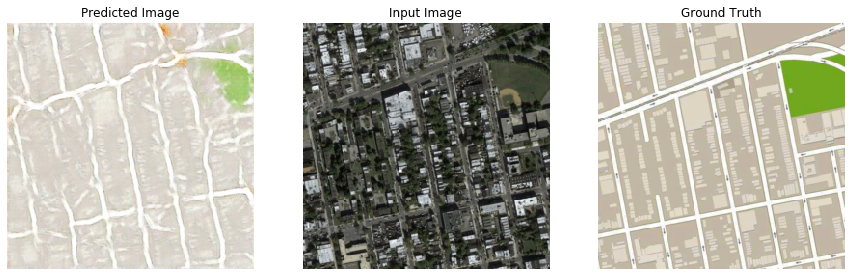

In [12]:
train_dataset = Maps(files=train_files, mode='train')
val_dataset = Maps(files=val_files, mode='validation')

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

gen = Generator().to(device)
gen.weight_init(mean=0.0, std=0.02)

disc = Discriminator().to(device)
disc.weight_init(mean=0.0, std=0.02)

gen_opt = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.0002, betas=(0.5, 0.999))

losses = {'gen_loss': [],
          'disc_loss': []} 

epochs = 10

BCELoss = torch.nn.BCELoss()
L1_loss = torch.nn.L1Loss().cuda()

for epoch in range(epochs):
    losses = {'gen_loss': [],
              'disc_loss': []}  
    for input_image, target in train_loader:
        with torch.autograd.set_detect_anomaly(True):
            input_image = input_image.cuda()
            target = target.cuda()          
            
            disc_vs_real = disc(input_image, target).squeeze()
            real_ones = torch.ones(disc_vs_real.size()).cuda()
            disc_real_loss = BCELoss(disc_vs_real, real_ones)
                       
            gen_output = gen(input_image)
            disc_vs_gen = disc(input_image, gen_output).squeeze()
            fake_zeros = torch.zeros(disc_vs_gen.size()).cuda()
            
            disc_gen_loss = BCELoss(disc_vs_gen, fake_zeros)
            disc_loss = (disc_real_loss + disc_gen_loss)*0.5
            disc.zero_grad()
            disc_loss.backward()
            disc_opt.step()
            
            gen_output = gen(input_image)
            disc_vs_gen = disc(input_image, gen_output)
            gan_loss = BCELoss(disc_vs_gen, real_ones)
            
            l1_loss =  100 * L1_loss(gen_output, target)
            
            gen_loss = gan_loss+l1_loss
            gen.zero_grad()
            gen_loss.backward()
            gen_opt.step()
            
            losses['gen_loss'].append(gen_loss.detach().cpu().float().item())
            losses['disc_loss'].append(disc_loss.detach().cpu().float().item())
            
            clear_output(wait=True)
            print('Epoch: ',epoch)
            for key in losses:
                print(key, ' ', losses[key][-1]) 
            
            test_input, test_truth = next(iter(val_loader))
            gen_image = gen(test_input.cuda())
            gen_image = gen_image.cpu().data            
            show_images(gen_image, test_input, test_truth)        